In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns

In [2]:
bag = rosbag.Bag('/home/uware/rosbags/dynamic/rotational/90/1m/36h11.bag')

# create variables
target = 'is_detected'

# we are interested if tag is detected at 90°/s

In [3]:
topic = '/tag_detections'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    time = t

    # we only care if there is or there isn't a detection in message published and consider there is only one tag in the frame
    is_detected = len(msg.detections)

    # detection orientations are only for information, it is not being used for anything
    if is_detected>0:
        orientation_quat = msg.detections[0].pose.pose.pose.orientation
        pitch, yaw, roll = tf.transformations.euler_from_quaternion([orientation_quat.x,orientation_quat.y,orientation_quat.z,orientation_quat.w], axes='rxyz')
        row={'time': time.to_sec(), target: is_detected, 'roll': np.degrees(roll), 'pitch': np.degrees(pitch), 'yaw': np.degrees(yaw)}

    else:
        row={'time': time.to_sec(), target: is_detected, 'roll': None, 'pitch': None, 'yaw': None}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target).head(2)

,is_detected,roll,pitch,yaw,relative_time
0,1,78.409717,174.583389,-0.310196,0.000000
1,1,62.945011,172.809056,0.069038,0.790701


In [5]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

1    100.0
Name: is_detected, dtype: float64

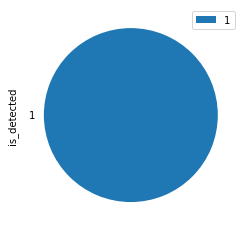

In [6]:
ratios.plot.pie()
plt.legend()

In [7]:
df.head(5)

,is_detected,roll,pitch,yaw,relative_time
0,1,78.409717,174.583389,-0.310196,0.000000
1,1,62.945011,172.809056,0.069038,0.790701
2,1,106.393167,175.168712,0.055588,1.596102
3,1,82.949155,175.143555,-0.661643,2.171032
4,1,67.275544,175.066614,1.550840,2.882051


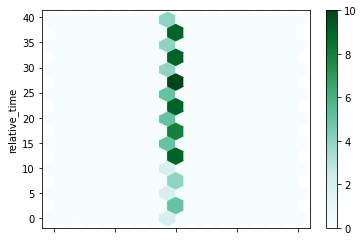

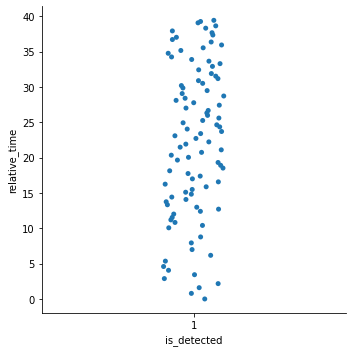

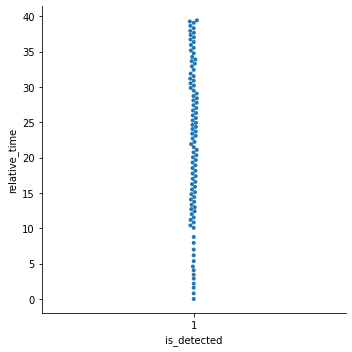

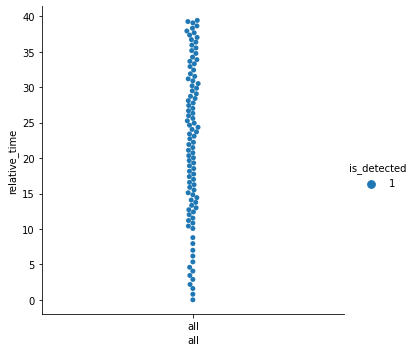

In [8]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")

In [9]:
df.roll.describe()

count     96.000000
mean      86.921925
std       19.581471
min       56.198888
25%       68.156791
50%       87.814227
75%      104.464960
max      118.757913
Name: roll, dtype: float64